In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from itertools import product
#plt.style.use('/home/rfajber/figs/rfgrey.mplstyle')

%autosave 60

Autosaving every 60 seconds


(array([-1.+6.28318531j, -1.-6.28318531j]), array([[0.70710678+0.j        , 0.70710678-0.j        ],
       [0.        -0.70710678j, 0.        +0.70710678j]]))


Text(0.5, 1.0, 'Xtrue')

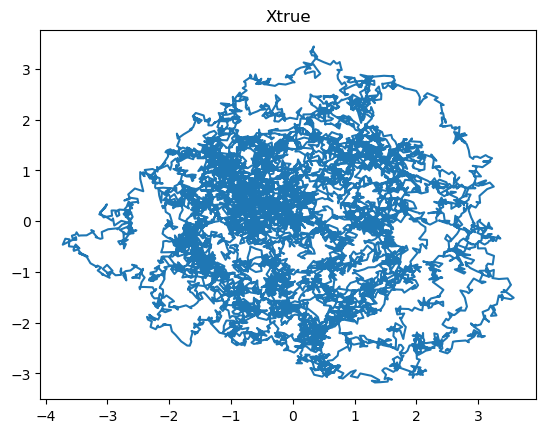

In [2]:
# set up the matrix and check that its stable

dt = 0.001
T = 10
N = int(T/dt)
t = np.linspace(0,T,N)

M = 2

tau_relax = 1
tau_rotate = 1
A = np.array([
              [-1/tau_relax,-2*np.pi/tau_rotate ],
              [2*np.pi/tau_rotate,-1/tau_relax]])
Am = la.expm(A*dt)
# need to make sure that the real parts of the eigenvalues are negative or this won't work!
print(la.eig(A))

s = 2 #np.sqrt(2/(np.sqrt(tau_relax)))
B = np.array([s,s])*np.sqrt(dt)

# lets do 1 simulation and call it "truth"
Xtrue = np.zeros([M,N])
for i in range(1,N):
    w = np.random.randn(M)
    Xtrue[:,i] = np.dot( Am, Xtrue[:,i-1] ) + B*w

#take a look at the the phase plot, should be orbits.
plt.plot(Xtrue[0],Xtrue[1])
plt.title('Xtrue')

In [3]:
# storage for the state and the cocvariance matrix 
Xfilter = np.zeros([M,N])

gammaB = np.dot(B.T,B)

Pfilter = np.zeros([M,M,N])
Pfilter[:,:,0] = gammaB

Hobs=np.array([[1,0]])
nobs = 1

# the noise that we are adding to the "truth"
R=0.1*np.eye(nobs)
gammaR = np.dot(R.T,R)

Zobs = np.dot(Hobs,Xtrue) + np.dot(R,np.random.randn(nobs,N))

# sampling rate 
tsamp = 0.6
nsample = tsamp//dt

# this is a counter to see how often we need to do the update
ns = 1

for i in range(1,N):

    # linear forecasts 
    # for the state space the estimate is the ensemble mean, so we can ignore the random term
    Xforecast = np.dot( Am, Xfilter[:,i-1] ) 
    Pforecast = np.dot( Am, np.dot(Pfilter[:,:,i-1], Am.T) ) + gammaB
        
    #check if we need to do a filter update 
    if ns == nsample-1:
        
        print(f'Analysis: {i}')

        # obs innovation 
        y = Zobs[:,i] - np.dot(Hobs,Xforecast)
        
        # part of the kalman gain that we will have to invert
        S = np.dot( np.dot(Hobs, Pforecast), Hobs.T) + gammaR

        # kalman gain matrix     
        K = np.dot( Pforecast, np.dot( Hobs.T, la.inv(S) ) )
            
        # analysis updates
        Xfilter[:,i] = Xforecast + np.dot(K,y)
        Pfilter[:,:,i] = np.dot( np.eye(M) - np.dot(K,Hobs) , Pforecast)

        # reset the counter         
        ns = 0

    # if no update, put the forecast into the filter         
    else:
        
        Xfilter[:,i] = Xforecast 
        Pfilter[:,:,i] = Pforecast
        
        ns+=1
    

Analysis: 598
Analysis: 1197
Analysis: 1796
Analysis: 2395
Analysis: 2994
Analysis: 3593
Analysis: 4192
Analysis: 4791
Analysis: 5390
Analysis: 5989
Analysis: 6588
Analysis: 7187
Analysis: 7786
Analysis: 8385
Analysis: 8984
Analysis: 9583


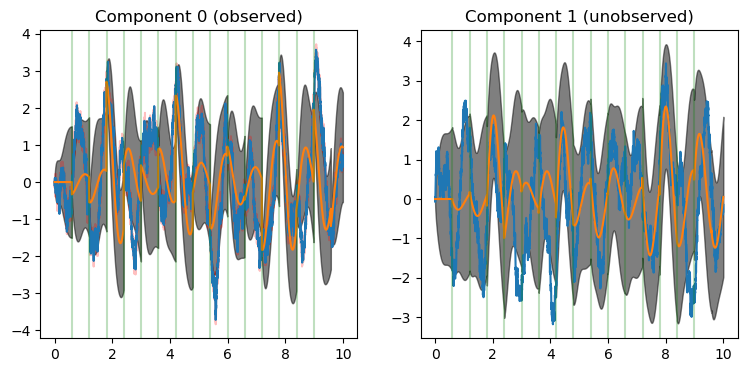

In [4]:
# make some plots and see how well the filter worked!
# I've tried to pick some parameters in this example so the filter is working, but not that well. 
# try changing the sampling frequency and the noise strength to see what values work and which don't.
# you should be able to make some guesses about nsample and R based on some of the model parameters 

# use the variances in the covariance matrix to estimate some error bounds
est_err=np.sqrt(np.vstack([Pfilter[0,0],Pfilter[1,1]]))
xrangep=Xfilter+est_err
xrangem=Xfilter-est_err

plt.figure(0,figsize=(9,4))
titles=['Component 0 (observed)','Component 1 (unobserved)']
for k in range(0,2):
    plt.subplot(1,2,k+1)
    plt.fill_between(t,xrangem[k],xrangep[k],alpha=0.5,color='k')
    if k==0:
        plt.plot(t,Zobs[0],color='r',alpha=0.25)
    plt.plot(t,Xtrue[k])
    plt.plot(t,Xfilter[k])
    for i in range(1,int(T/tsamp)):
        plt.axvline(i*tsamp,color='green',alpha=0.25)
    plt.title(titles[k])
